In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
from nbodykit.source.catalog import ArrayCatalog
from nbodykit.lab import FFTPower

In [3]:
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog

In [4]:
def measure_pkl(pos, uzs, Lbox=2000, nc=128, dk=0.005, los=0):

    hpos = 1.0 * pos
    hpos[:,los] += uzs[:,los]

    data = {'Position':hpos}
    hcat = ArrayCatalog(data)
    hmesh = hcat.to_mesh(Nmesh=nc, BoxSize=Lbox, compensated=True, window='tsc',interlaced=True)

    r = FFTPower(hmesh, mode='2d',poles=[0,2,4],los=[0,0,1],Nmu=5, dk=dk)    
    k, Nk, p0k, p2k, p4k = r.poles['k'], r.poles['modes'], r.poles['power_0'].real, r.poles['power_2'].real, r.poles['power_4'].real

    sn = r.power.attrs['shotnoise']

    return k, p0k, p2k, p4k, sn, Nk, r, hmesh

In [5]:
def measure_pnm(pos, us, Lbox=2000, nc=128, dk=0.005, max_order = 4, redshift_space=False, los=2):

    hpos = 1.0 * pos

    if redshift_space:
        hpos[:,los] += us[:,los]

    # force back into box:
    iis = hpos[:,los] > Lbox/2
    hpos[iis,los] -= Lbox

    iis = hpos[:,los] < -Lbox/2
    hpos[iis,los] += Lbox
    
    data = {'Position':hpos}
    hcat = ArrayCatalog(data)
    
    meshes = []
    
    for ii in range(max_order+1):
        vel_name = 'u%d'%(ii)
        hcat[vel_name] = us[:,los]**ii
        meshes += [hcat.to_mesh(Nmesh=nc, BoxSize=Lbox, compensated=True, window='tsc', interlaced=True, position='Position',value=vel_name),]

    ret = []

    ells = [0, 1, 2, 3, 4]
    
    for vel_order in range(max_order+1):

        #print("Now computing spectra with %d velocities"%(vel_order))
    
        counter = 0
        data = []
        #header = ''
        for ii in range(vel_order+1):
            jj = vel_order - ii
            
            if jj >= ii: # only distinct pairs
                #header += ' (%d,%d) |'%(ii,jj)
                nvec = np.array([0,0,0])
                nvec[los] = 1
                rij = FFTPower(meshes[jj], mode='1d', poles=list(ells), second=meshes[ii], los=nvec,dk=dk) 
            
                if counter == 0:
                    data += [rij.poles['k'],]
            
                if vel_order%2 == 0:
                    data += [ rij.poles['power_%d'%(ell)].real for ell in ells ]
                else:
                    data += [ rij.poles['power_%d'%(ell)].imag for ell in ells ]
            
                counter += 1
        
        ret += [data,]
    
    return ret

In [6]:
basedir = '/global/cfs/cdirs/desi/public/cosmosim/AbacusSummit/'

In [10]:
logMmin = 12.5
logMmax = 13.0
z = 0.1

In [11]:
for ii in range(1):

    print(ii)
    
    sample = f'AbacusSummit_base_c000_ph{ii:03}/halos/z{z:.3f}'
    filename = basedir + sample

    cat = CompaSOHaloCatalog(basedir+sample,fields=('x_com','v_com','N'))
    
    particle_mass = cat.header['ParticleMassHMsun'] # / (cat.header['H0']/100)
    Ms = cat.halos['N'] * particle_mass
    mass_iis = (Ms > 10.**logMmin) * (Ms < 10**logMmax)
    cat.halos = cat.halos[mass_iis]

    Lbox = cat.header['BoxSize']
    nc = 256

    OmegaM = cat.header['Omega_M']
    z = cat.header['Redshift']
    Ez = np.sqrt(OmegaM * (1+z)**3 + 1 - OmegaM)
    vfac = 0.01 * (1 + z) / Ez # convert km/s to h^{-1} Mpc, u = v / (aH) = v * (1+z) / (100 * E(z))
    uz = cat.halos['v_com'] * vfac


    res = measure_pkl(cat.halos['x_com'], uz, Lbox=Lbox, nc=nc, dk=0.005)

print(res)

0


/global/homes/s/sfschen/.conda/envs/nbodykit_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  


0.45124655961990356
(array([0.00379811, 0.00829934, 0.01293223, 0.0176484 , 0.02256549,
       0.02777644, 0.03269805, 0.03761648, 0.04263844, 0.04756515,
       0.05262096, 0.05756032, 0.06254738, 0.06757793, 0.07255918,
       0.07753384, 0.08251793, 0.08752752, 0.09254702, 0.09754963,
       0.10253196, 0.1075116 , 0.11251029, 0.11755009, 0.12253694,
       0.1275261 , 0.13253021, 0.13750627, 0.14251344, 0.14752592,
       0.15252994, 0.15749457, 0.16251893, 0.1675461 , 0.1725292 ,
       0.1775302 , 0.18251477, 0.18753607, 0.19253237, 0.19751987,
       0.20251537, 0.20750885, 0.21251781, 0.21750042, 0.22250932,
       0.22752896, 0.23252854, 0.23752766, 0.2424991 , 0.24749986,
       0.25252003, 0.25751823, 0.26252557, 0.26753055, 0.27254046,
       0.27753332, 0.28251239, 0.28751047, 0.29249713, 0.29750588,
       0.30251214, 0.30750104, 0.31251342, 0.31751597, 0.32252214,
       0.32751817, 0.33251238, 0.33749594, 0.34249192, 0.34751798,
       0.35250529, 0.35751333, 0.36252502

In [12]:
cat.header

{'AllowGroupFinding': 1,
 'BackupDirectory': '/gpfs/alpine/proj-shared/ast145/AbacusSummit/AbacusSummit_base_c000_ph000',
 'BackupStepInterval': -1,
 'BoxSize': 2000.0,
 'BoxSizeHMpc': 2000.0,
 'BoxSizeMpc': 2969.1211401425176,
 'CPD': 1701,
 'CodeVersion': '8d43e2d166b9bcb0168a6ca49a4643d06bfb2625',
 'Conv_IOCores': 0,
 'Conv_IOMode': 'overwrite',
 'Conv_OMP_NUM_THREADS': 42,
 'Conv_OMP_PLACES': '{0}:21:4,{88}:21:4',
 'Conv_OMP_PROC_BIND': 'spread',
 'Conv_zwidth': 0,
 'ConvolutionCacheSizeMB': 200,
 'ConvolutionL1CacheSizeMB': 0.015625,
 'CoordinateDistanceHMpc': 292.5861830707283,
 'DeleteICsAfterFirstBackup': 1,
 'DeltaEtaDrift': 0.0007023815099787001,
 'DeltaRedshift': 0.000670922877507,
 'DeltaScaleFactor': 0.000554143728125,
 'DeltaTime': 0.000580126734663,
 'DensityKernelRad': 0.4,
 'DensityKernelRad2': 3.34898e-09,
 'DerivativeExpansionRadius': 8,
 'DerivativesDirectory': '/gpfs/alpine/proj-shared/ast145/Derivatives',
 'DirectBPD': 2,
 'Do2LPTVelocityRereading': 0,
 'DoublePre

In [ ]:
p0ks, p2ks, p4ks = [], [], []
v1ks, v3ks = [], []
s0ks, s2ks = [], []


for ii in range(25):

    print(ii)
    
    sample = f'AbacusSummit_base_c000_ph{ii:03}/halos/z{z:.3f}'
    filename = basedir + sample

    cat = CompaSOHaloCatalog(basedir+sample,fields=('x_com','v_com','N'))
    
    particle_mass = cat.header['ParticleMassHMsun'] # / (cat.header['H0']/100)
    Ms = cat.halos['N'] * particle_mass
    mass_iis = (Ms > 10.**logMmin) * (Ms < 10**logMmax)
    cat.halos = cat.halos[mass_iis]

    Lbox = cat.header['BoxSize']
    nc = 256

    OmegaM = cat.header['Omega_M']
    z = cat.header['Redshift']
    Ez = np.sqrt(OmegaM * (1+z)**3 + 1 - OmegaM)
    vfac = 0.01 * (1 + z) / Ez # convert km/s to h^{-1} Mpc, u = v / (aH) = v * (1+z) / (100 * E(z))
    uz = cat.halos['v_com'] * vfac


    res = measure_pnm(cat.halos['x_com'], uz, Lbox=Lbox, nc=nc, dk=0.005, max_order=2, redshift_space=True, los=0)

    kk, p0k, p1k, p2k, p3k, p4k = res[0]

    kk, p01_0, p01_1, p01_2, p01_3, p01_4 = res[1]

    kk, p02_0, p02_1, p02_2, p02_3, p02_4, p11_0, p11_1, p11_2, p11_3, p11_4 = res[2]

    p0ks += [p0k,]
    p2ks += [p2k,]
    p4ks += [p4k,]
    v1ks += [-2j * p01_1,]
    v3ks += [-2j * p01_3,]
    s0ks += [(2*p02_0 - 2*p11_0),]
    s2ks += [(2*p02_2 - 2*p11_2),]



## Assemble Covariance

In [38]:
dvecs = []

for ii in range(25):
    dvecs += [ np.concatenate((p0ks[ii].real, p2ks[ii].real, p4ks[ii].real, v1ks[ii].imag, v3ks[ii].imag, s0ks[ii].real, s2ks[ii].real)), ]

dvecs = np.array(dvecs)

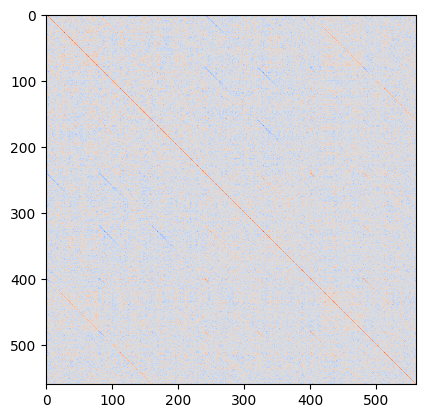

In [39]:
cov = np.cov(dvecs.T)
sigmas = np.diag(cov)**0.5

plt.imshow(cov / sigmas[:,None] / sigmas[None,:], cmap='coolwarm')

In [40]:
# Clean Up
Nk = len(k)
Nspec = 7

cov_diag = np.zeros((Nspec*Nk, Nspec*Nk))

for ii in range(Nspec):

    for jj in range(Nspec):

        start_ii, start_jj = ii * Nk, jj * Nk
        
        for ind in range(Nk):

            cov_diag[start_ii + ind, start_jj + ind] = cov[start_ii + ind, start_jj + ind]

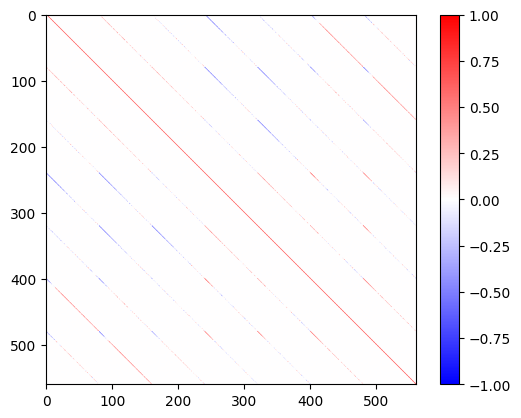

In [41]:
mask = (cov_diag == 0)

corr = cov_diag / sigmas[:,None] / sigmas[None,:]

plt.imshow(corr, vmin=-1, vmax=1, cmap='bwr')

plt.colorbar()
plt.show()

In [43]:
filebase = "pvs/"+"_".join(sample.split("_")[:3]) + '_' + sample.split("_")[-1][-6:] + '_' + f'{logMmin:.1f}' + '_' + f'{logMmax:.1f}'

In [44]:
np.savetxt(filebase + '_xins_rsd_periodic_los_x.txt', np.array([k,\
                                             np.mean(p0ks,axis=0).real,\
                                             np.mean(p2ks,axis=0).real,\
                                             np.mean(p4ks,axis=0).real,\
                                             np.mean(v1ks, axis=0).imag,\
                                             np.mean(v3ks, axis=0).imag,\
                                             np.mean(s0ks, axis=0).real, np.mean(s2ks, axis=0).real,\
                                                ]).T)

In [45]:
np.savetxt(filebase + '_xins_rsd_cov_los_x.txt', cov_diag)